In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
df = pd.read_csv('../../Visualization/OASIS/oasis_3.csv')
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df.loc[df['Diagnosis'] == 'control', 'Diagnosis'] = -1
df.loc[df['Diagnosis'] == 'dementia', 'Diagnosis'] = 1
df = df.drop(['MR ID', 'Freesurfer ID', 'M/F', 'cdr', 'apoe'], axis=1) # Drop categorical and redundant columns
df_drop_discrete = df.drop(['mmse'], axis=1)# Drop discrete variables
#df = df.drop(['lhCortexVol', 'rhCortexVol', 'lhCorticalWhiteMatterVol', 'rhCorticalWhiteMatterVol', 'L.SurfArea', 'R.SurfArea'], axis=1) # Test drop to reduce dimensionality

In [3]:
df.head()

,Diagnosis,Age,mmse,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,
OAS30001,-1,73.0,30.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,-1,73.0,29.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,-1,66.0,29.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,-1,61.0,30.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,-1,54.0,30.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


In [4]:
df.Diagnosis.value_counts()

-1    712
 1    310
Name: Diagnosis, dtype: int64

<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

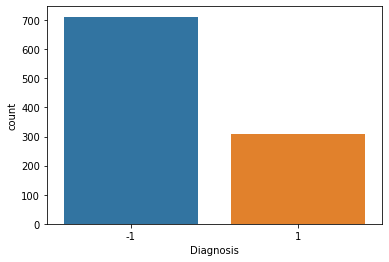

In [5]:
sns.countplot(df['Diagnosis'])

In [6]:
# standard z score scaling
def scale(X):
    u = np.mean(X)
    s = np.std(X)
    X_scaled = (X-u)/s
    return X_scaled

## SVM Model

In [7]:
class SVM:
    # Larger lambda gives a wider margin and smaller lambda results in the narrow margin
    # for infinitely small λ the SVM becomes hard margin
    def __init__(self, learning_rate=0.001, lambd=0.01, n_iters=10000):
        self.lr = learning_rate
        self.lambd = lambd
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_conv = np.array(y)

        self.w = np.random.normal(size=n_features)
        self.b = np.random.normal()

        for i in tqdm(range(self.n_iters)):
            for idx, x_i in enumerate(X):
                #print(idx, x_i)
                if y_conv[idx] * (np.dot(x_i, self.w) - self.b) >= 1:
                    dw = 2 * self.lambd * self.w
                    #dw = 2 * 1/(i+1) * self.w
                    db = 0
                    self.w -= self.lr * dw
                    self.b -= self.lr * db
                else:
                    dw = 2 * self.lambd * self.w - np.dot(x_i, y_conv[idx])
                    #dw = 2 * 1/(i+1) * self.w - np.dot(x_i, y_conv[idx])
                    db = y_conv[idx]
                    self.w -= self.lr * dw
                    self.b -= self.lr * db

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

## Discrete variables included

In [8]:
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(817, 15) (205, 15) (817,) (205,)


In [9]:
X_train = scale(X_train)
X_test = scale(X_test)

In [10]:
X_train.head()

,Age,mmse,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,
OAS30878,0.448106,-1.208432,-0.067708,0.782224,1.226312,1.175484,1.207035,3.754129,1.684925,0.988592,1.267389,1.214855,1.245408,1.451690,1.376693
OAS30238,0.555974,-1.735971,0.718602,0.949192,-0.105834,-0.035205,-0.070932,-0.322263,-0.019374,0.160041,0.048756,0.161969,0.105899,0.721170,0.854318
OAS30410,0.340239,-1.208432,-0.858881,0.067149,-0.326245,-0.508100,-0.419150,-0.381080,-0.363781,-0.233953,-0.720655,-0.632547,-0.678850,-0.357457,-0.416994
OAS30006,-0.306967,0.637954,0.403696,2.408306,1.462854,1.529346,1.503645,-0.056995,1.674911,2.206051,2.229444,2.031146,2.137492,2.817108,2.543211
OAS30405,0.448106,0.374185,0.046934,-1.164770,-1.667141,-1.769032,-1.726731,-0.372241,-1.629095,-1.643420,-1.438092,-1.290820,-1.369036,-1.690702,-1.529658


In [11]:
model = SVM()
model.fit(np.array(X_train), y_train)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
predictions = model.predict(X_test)

In [13]:
correct_preds = np.sum(predictions == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')

Accuracy: 0.8731707317073171


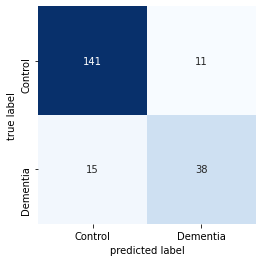

In [14]:
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, predictions)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

In [15]:
for i in range(X_test.columns.shape[0]):
    if(model.w[i] < 0):
        print("%-27s %-3s %f" % (X_test.columns[i], ':', model.w[i]))
    else:
        print("%-27s %-3s  %f" % (X_test.columns[i], ':',  model.w[i]))
print(f'Bias value of model: {model.b}')

Age                         :   -0.148144
mmse                        :   -1.370535
TotalHippocampusVol         :   -0.514508
IntraCranialVol             :    0.326092
lhCortexVol                 :   -0.006247
rhCortexVol                 :   -0.121368
CortexVol                   :   -0.064042
SubCortGrayVol              :    0.052347
TotalGrayVol                :    0.111972
SupraTentorialVol           :    0.092679
lhCorticalWhiteMatterVol    :    0.026305
rhCorticalWhiteMatterVol    :   -0.167310
CorticalWhiteMatterVol      :   -0.071034
L.SurfArea                  :    0.030153
R.SurfArea                  :   -0.043674
Bias value of model: 0.5709764248591092


## Dropping discrete variables

In [16]:
X2 = df_drop_discrete.drop(['Diagnosis'], axis=1)
y2 = df_drop_discrete['Diagnosis']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
X_train2 = scale(X_train2)
X_test2 = scale(X_test2)
X_train2.head()

,Age,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,
OAS30878,0.448106,-0.067708,0.782224,1.226312,1.175484,1.207035,3.754129,1.684925,0.988592,1.267389,1.214855,1.245408,1.451690,1.376693
OAS30238,0.555974,0.718602,0.949192,-0.105834,-0.035205,-0.070932,-0.322263,-0.019374,0.160041,0.048756,0.161969,0.105899,0.721170,0.854318
OAS30410,0.340239,-0.858881,0.067149,-0.326245,-0.508100,-0.419150,-0.381080,-0.363781,-0.233953,-0.720655,-0.632547,-0.678850,-0.357457,-0.416994
OAS30006,-0.306967,0.403696,2.408306,1.462854,1.529346,1.503645,-0.056995,1.674911,2.206051,2.229444,2.031146,2.137492,2.817108,2.543211
OAS30405,0.448106,0.046934,-1.164770,-1.667141,-1.769032,-1.726731,-0.372241,-1.629095,-1.643420,-1.438092,-1.290820,-1.369036,-1.690702,-1.529658


In [17]:
model2 = SVM()
model2.fit(np.array(X_train2), y_train2)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
predictions2 = model2.predict(X_test2)
correct_preds2 = np.sum(predictions2 == y_test2)
print(f'Accuracy: {correct_preds2/y_test2.size}')

Accuracy: 0.7804878048780488


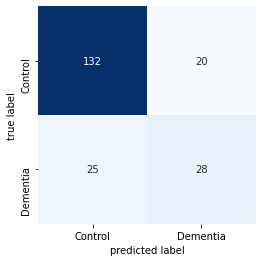

In [19]:
np_y_test2 = np.array(y_test2).astype(int)
mat2 = confusion_matrix(np_y_test2, predictions2)
sns.heatmap(mat2, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

In [20]:
for i in range(X_test2.columns.shape[0]):
    if(model2.w[i] < 0):
        print("%-27s %-3s %f" % (X_test2.columns[i], ':', model2.w[i]))
    else:
        print("%-27s %-3s  %f" % (X_test2.columns[i], ':',  model2.w[i]))
print(f'Bias value of model: {model2.b}')

Age                         :   -0.214900
TotalHippocampusVol         :   -0.862241
IntraCranialVol             :    0.704314
lhCortexVol                 :   -0.209437
rhCortexVol                 :   -0.201835
CortexVol                   :   -0.206686
SubCortGrayVol              :    0.025700
TotalGrayVol                :    0.067135
SupraTentorialVol           :    0.010336
lhCorticalWhiteMatterVol    :   -0.065559
rhCorticalWhiteMatterVol    :   -0.046363
CorticalWhiteMatterVol      :   -0.056129
L.SurfArea                  :    0.038817
R.SurfArea                  :    0.071274
Bias value of model: 0.8161784034357092


## Visualization

In [21]:
def visualize_svm(ax, X_test, y_test, predictions, clf, feature_1, feature_2):
    X = np.array(X_test)
    def get_hyperplane_value(x, w, b, offset):
        return (-w[feature_1] * x + b + offset) / w[feature_2]

    # control prediction, control true
    idx = np.where((y_test==-1) & (predictions==-1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="+", c='C0', label="Pred:C, True:C")
    # control prediction, dementia true
    idx = np.where((y_test==1) & (predictions==-1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="+", c='C1', label="Pred:C, True:D")
    # dementia prediction, dementia true
    idx = np.where((y_test==1) & (predictions==1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="x", c='C1', label="Pred:D, True:D")
    # dementia prediction, control true
    idx = np.where((y_test==-1) & (predictions==1))
    ax.scatter(X[idx, feature_1], X[idx, feature_2], marker="x", c='C0', label="Pred:D, True:C")

    x0_1 = np.amin(X[:, feature_1])
    x0_2 = np.amax(X[:, feature_1])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, feature_2])
    x1_max = np.amax(X[:, feature_2])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    ax.set_xlabel(X_test.columns[feature_1])
    ax.set_ylabel(X_test.columns[feature_2])
    ax.set_title(f'{X_test.columns[feature_2]} vs {X_test.columns[feature_1]}')
    ax.legend()

    return ax

In [22]:
# orange is dementia true, blue is control true
# x is dementia prediction, + is control prediction
def save_figs(X_test, y_test, predictions, model, df_type):
    for feature_1 in range(X_test.shape[1]):
        fig, axes = plt.subplots(7, 2, figsize=(16,40))
        axes = axes.flatten()
        i = 0
        for feature_2 in range(X_test.shape[1]):
            if feature_1 == feature_2:
                continue
            axes[i] = visualize_svm(axes[i], X_test, y_test, predictions, model, feature_1, feature_2)
            i+=1
        fig.savefig(fname=f'svm_graphs/{df_type}/{X_test.columns[feature_1]}.png', facecolor='white')

In [23]:
#save_figs(X_test2, y_test2, predictions2, model2, "no_discrete")

In [24]:
#save_figs(X_test, y_test, predictions, model, "yes_discrete")